In [2]:
import csv
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime
from textblob import TextBlob
import matplotlib.pyplot as plt
from langdetect import detect


from nltk.corpus import stopwords

In [63]:
df = pd.read_csv('tweets.csv',dtype=object, sep = ';')

KeyboardInterrupt: 

In [ ]:
df['timestamp'] =  pd.to_datetime(df['timestamp'],errors='coerce')

In [ ]:
mask = (df['timestamp'].dt.date > datetime(2018, 11, 23).date()) & (df['timestamp'].dt.date <= datetime(2019, 3, 29).date())
df = df.loc[mask]

In [ ]:
df.shape

In [ ]:
df.shape

In [138]:
def single_preprocessing(document):
    """
    This function performs for a single text all preprocessing steps
    parameter: text as string
    output: list of that contains the preprocessed tokens
    """
        
    # preprosessing of the stopwords:
    lemmatizer = WordNetLemmatizer()
    
    stop_words = list(set(stopwords.words('english')))
    
    preprocessed_stop_words = []
    
    for k in np.arange(len(stop_words)):
        text= ""
        for i in np.arange(len(stop_words[k])):
            if stop_words[k][i].isalpha() or stop_words[k][i].isspace():
                text += stop_words[k][i].lower()
        text = lemmatizer.lemmatize(text)
        preprocessed_stop_words.append(text)
    
    # preprosessing of the actual text
    
    # list containing the regexes to clean the texts for not wanted pattern
    regex_list = ['https:(\S){1,}','www.(\S){1,}']
    
    # list to save the preprocessed text
    preprocessed_document = []

    # use the regex list to remove unwanted pattern
    for i in np.arange(len(regex_list)):
        document = re.sub(regex_list[i], '', document, count=0, flags=0)

    # remove non-alphabetical chars except space and split the text into a list of tokens
    text= ""
    for i in np.arange(len(document)):
        if document[i].isalpha() or document[i].isspace():
            text += document[i].lower()
    text_split = text.split()

    # lemmatize each token and remove it if it is part of the stopwords
    #print("Before:",len(text_split))
    for i in text_split:
        if i not in preprocessed_stop_words:
            preprocessed_document.append(i)
            
#     print("After:",len(preprocessed_document))
    
    
    return ' '.join(preprocessed_document)

In [139]:
def nested_preprocessing(corpus):
    """
    This function performs for a list of texts all preprocessing steps
    parameter: list of texts
    output: list of lists containing where each contained lists contains the preprocessed tokens
    """
    
    preprocessed_corpus = [single_preprocessing(k) for k in corpus]

    return preprocessed_corpus

In [140]:
df = df.dropna(subset=['text'])

In [141]:
df['preprocessed_text'] = df4['text'].apply(single_preprocessing)

In [ ]:
language = []

for key, value in enumerate(df['preprocessed_text']):
    try:
        lang = detect(value)
        language.append(lang)
    except:
        language.append('no_language')

No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text


In [ ]:
df['language'] = language

In [ ]:
df['language'].value_counts()

In [ ]:
df = df[df['language'] == 'en']

In [73]:
df = df[df['text'].str.contains('Giveaway')==False]
df = df[df['text'].str.contains('Cashback')==False]
df = df[df['text'].str.contains('Airdrop')==False]
df = df[df['text'].str.contains('nft')==False]
df = df[df['text'].str.contains('giveaway')==False]
df = df[df['text'].str.contains('giveaway')==False]

In [76]:
df.to_csv('processed_tweets.csv', index=False)

In [90]:
df = pd.read_csv('processed_tweets.csv',dtype=object, sep = ',')

In [91]:
df['timestamp'] =  pd.to_datetime(df['timestamp'],errors='coerce')

In [92]:
df['likes'] = df['likes'].astype(int)
df['retweets'] = df['retweets'].astype(int)

In [42]:
df_test = df.head(10).copy()

In [6]:
# mask = (df['likes'] > 5) | (df['retweets'] > 5)

In [7]:
# df = df.loc[mask]

In [93]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [9]:
# finBERT:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",num_labels=3)
nlp = pipeline("sentiment-analysis",model=model,tokenizer=tokenizer)

In [10]:
analyzer = SentimentIntensityAnalyzer()

In [11]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
 
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def analyze_sentiment_pos(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return str(sentiment_dict['pos'])

def analyze_sentiment_Neg(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return sentiment_dict['neg']

def analyze_sentiment_Neu(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return sentiment_dict['neu']

def analyze_sentiment_Comp(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return sentiment_dict['compound']

def analyze_sentiment_finBERT_int(tweet):
    sentiment_dict = nlp(tweet)
    return sentiment_dict[0]['score']

def analyze_sentiment_finBERT(tweet):
    sentiment_dict = nlp(tweet)
    if sentiment_dict[0]['label']=='positive':
      return 2
    elif sentiment_dict[0]['label']=='neutral':
      return 1
    else: return -1
    
def analyze_finBERT(tweet):
    sentiment_dict = nlp(tweet)
    if sentiment_dict[0]['label']=='positive':
      return pd.Series([2, sentiment_dict[0]['score']])
    elif sentiment_dict[0]['label']=='neutral':
      return pd.Series([1, sentiment_dict[0]['score']])
    else: return pd.Series([-1, sentiment_dict[0]['score']])

In [ ]:
df["Vader_Comp"] = df['preprocessed_text'].apply(analyze_sentiment_Comp)
df["Vader_Pos"] = df['preprocessed_text'].apply(analyze_sentiment_pos)
df["Vader_Neg"] = df['preprocessed_text'].apply(analyze_sentiment_Neg)
df["Vader_Neu"] = df['preprocessed_text'].apply(analyze_sentiment_Neu)

In [97]:
from tqdm import tqdm

In [98]:
results = []

# Iterate over the column values of a certain column
for value in tqdm(df_test['preprocessed_text']):
    # Perform the resource-intensive operation
    result = analyze_finBERT(value)
    results.append(result)

# Create a new column in the dataframe with the results
df_test[["BERT_Sentiment", "BERT_SCORE"]] = results

NameError: name 'df_test' is not defined

In [ ]:
df.to_csv('bert_tweets.csv', index=False)

In [94]:
# twitter-roberta-base-sentiment-latest:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
nlp = pipeline("sentiment-analysis",model=model,tokenizer=tokenizer)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [95]:
def analyze_sentiment_roberta_int(tweet):
    sentiment_dict = nlp(tweet)
    return sentiment_dict[0]['score']

def analyze_sentiment_roberta(tweet):
    sentiment_dict = nlp(tweet)
    if sentiment_dict[0]['label']=='positive':
      return 2
    elif sentiment_dict[0]['label']=='neutral':
      return 1
    else: return -1
    
def analyze_roberta(tweet):
    sentiment_dict = nlp(tweet)
    if sentiment_dict[0]['label']=='positive':
      return pd.Series([2, sentiment_dict[0]['score']])
    elif sentiment_dict[0]['label']=='neutral':
      return pd.Series([1, sentiment_dict[0]['score']])
    else: return pd.Series([-1, sentiment_dict[0]['score']])

In [99]:
results = []

# Iterate over the column values of a certain column
for value in tqdm(df['text']):
    # Perform the resource-intensive operation
    result = analyze_roberta(value)
    results.append(result)

# Create a new column in the dataframe with the results
df[["roberta_Sentiment", "roberta_SCORE"]] = results

  0%|          | 870/417006 [03:56<31:23:47,  3.68it/s]


KeyboardInterrupt: 

In [46]:
df_test.head(10)

,id,user,fullname,url,timestamp,replies,likes,retweets,text,preprocessed_text,language,Vader_Comp,Vader_Pos,Vader_Neg,Vader_Neu,BERT_SCORE,BERT_Sentiment,roberta_Sentiment,roberta_SCORE
0,1105610249069883392,coinairdropall,Crypto Airdrops,NaN,2019-03-12,1,0,1,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,bitcoin satoshi crypto blockchain airdrop new ...,en,0.2263,0.091,0.000,0.909,0.895744,1,1.0,0.561111
1,1108810883290095616,Airdropnotecom,Crypto Airdrops,NaN,2019-03-21,0,13,13,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,bitcoin satoshi crypto blockchain airdrop new ...,en,0.9260,0.420,0.000,0.580,0.883305,1,2.0,0.609270
2,1104519969398816771,coinairdropall,Crypto Airdrops,NaN,2019-03-09,0,0,1,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,bitcoin satoshi crypto blockchain airdrop new ...,en,0.0000,0.000,0.000,1.000,0.900940,1,1.0,0.752385
3,1105606801914060801,CoinsAirdrops,Crypto Airdrops,NaN,2019-03-12,1,13,9,#Bitcoin #crypto #Airdrop\nNew Airdrop #p2pb2b...,bitcoin crypto airdrop new airdrop ppbb airdro...,en,0.5859,0.202,0.000,0.798,0.921648,1,1.0,0.598714
4,1078873154376880129,TheBitfi,Bitfi - open source: bitfi.dev,NaN,2018-12-29,9,61,16,The first lab made diamond happened in 1955 &a...,first lab made diamond happened amp flawless m...,en,0.6908,0.180,0.000,0.820,0.872292,1,2.0,0.814316
5,1105611129773006848,coinairdropall,Crypto Airdrops,NaN,2019-03-12,0,0,1,#Bitcoin #crypto #Airdrop\nNew Airdrop #Crypto...,bitcoin crypto airdrop new airdrop cryptosoul ...,en,-0.3818,0.000,0.094,0.906,0.830180,1,1.0,0.646247
6,1108499115334348801,Airdropnotecom,Crypto Airdrops,NaN,2019-03-20,2,8,8,#Bitcoin #Satoshi #crypto\nCrypto Wallet #XAPO...,bitcoin satoshi crypto crypto wallet xapo xapo...,en,0.6249,0.203,0.000,0.797,0.931054,1,1.0,0.583216
7,1105611397872996354,coinairdropall,Crypto Airdrops,NaN,2019-03-12,0,0,1,#Bitcoin #crypto #Airdrop\nNew Airdrop #Bitdep...,bitcoin crypto airdrop new airdrop bitdeposita...,en,0.7783,0.238,0.000,0.762,0.923276,1,1.0,0.675743
8,1105611682410315777,coinairdropall,Crypto Airdrops,NaN,2019-03-12,0,0,1,#Bitcoin #crypto #Airdrop\nNew Airdrop #p2pb2b...,bitcoin crypto airdrop new airdrop ppbb airdro...,en,0.5859,0.202,0.000,0.798,0.921648,1,1.0,0.592256
9,1100771310249095170,Airdropnotecom,Crypto Airdrops,NaN,2019-02-27,6,21,11,#Bitcoin #crypto #Airdrop\nNew Airdrop #BIGtok...,bitcoin crypto airdrop new airdrop bigtoken ea...,en,0.8126,0.344,0.000,0.656,0.632297,2,1.0,0.596951


In [ ]:
df.to_csv('bert_tweets.csv', index=False)

In [29]:
# df_test[["BERT_Sentiment", "BERT_SCORE"]] = df_test['preprocessed_text'].copy().apply(analyze_finBERT)

In [15]:
# df["BERT_SCORE"] = df['preprocessed_text'].apply(analyze_sentiment_finBERT_int)

In [16]:
# df.to_csv('bert_tweets.csv', index=False)

In [17]:
# df["BERT_Sentiment"] = df['preprocessed_text'].apply(analyze_sentiment_BERT)

In [18]:
# df.to_csv('bert_tweets.csv', index=False)

In [63]:
df = pd.read_csv('bert_tweets.csv')

In [64]:
df['timestamp'] =  pd.to_datetime(df['timestamp'],errors='coerce')

In [65]:
df['quantity'] = 1

In [66]:
df.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text,preprocessed_text,language,Vader_Comp,Vader_Pos,Vader_Neg,Vader_Neu,BERT_SCORE,BERT_Sentiment,quantity
0,1105610249069883392,coinairdropall,Crypto Airdrops,NaN,2019-03-12 23:23:19+00:00,1,0,1,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,bitcoin satoshi crypto blockchain airdrop new ...,en,0.2263,0.091,0.0,0.909,0.895744,1,1
1,1108810883290095616,Airdropnotecom,Crypto Airdrops,NaN,2019-03-21 19:21:29+00:00,0,13,13,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,bitcoin satoshi crypto blockchain airdrop new ...,en,0.9260,0.420,0.0,0.580,0.883305,1,1
2,1104519969398816771,coinairdropall,Crypto Airdrops,NaN,2019-03-09 23:10:56+00:00,0,0,1,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,bitcoin satoshi crypto blockchain airdrop new ...,en,0.0000,0.000,0.0,1.000,0.900940,1,1
3,1105606801914060801,CoinsAirdrops,Crypto Airdrops,NaN,2019-03-12 23:09:37+00:00,1,13,9,#Bitcoin #crypto #Airdrop\nNew Airdrop #p2pb2b...,bitcoin crypto airdrop new airdrop ppbb airdro...,en,0.5859,0.202,0.0,0.798,0.921648,1,1
4,1078873154376880129,TheBitfi,Bitfi - open source: bitfi.dev,NaN,2018-12-29 04:39:39+00:00,9,61,16,The first lab made diamond happened in 1955 &a...,first lab made diamond happened amp flawless m...,en,0.6908,0.180,0.0,0.820,0.872292,1,1


In [67]:
frequency = '6H'

In [68]:
df = df.resample(frequency, on='timestamp').agg({'quantity':'sum','BERT_Sentiment':'mean', 'Vader_Comp':'mean','likes':'sum','retweets':'sum','replies':'sum'})
df.rename(columns={'quantity': 'num_tweets', 'BERT_Sentiment': 'BERT_Sentiment_mean', 'Vader_Comp': 'Vader_Comp_mean', 'likes': 'likes_sum', 'retweets':'retweets_sum', 'replies':'replies_sum'}, inplace=True)
df.index.rename('time', inplace=True)

In [69]:
df.head()

,num_tweets,BERT_Sentiment_mean,Vader_Comp_mean,likes_sum,retweets_sum,replies_sum
time,,,,,,
2018-11-24 00:00:00+00:00,127,0.984252,0.025830,1382,486,204
2018-11-24 06:00:00+00:00,115,0.982609,0.061959,1147,1009,85
2018-11-24 12:00:00+00:00,149,0.993289,0.029923,3923,1054,200
2018-11-24 18:00:00+00:00,211,0.966825,0.083009,5160,1050,335
2018-11-25 00:00:00+00:00,172,0.970930,0.077348,5273,1265,436


In [70]:
btc = pd.read_csv('btcusd.csv')

In [71]:
btc['time'] =  pd.to_datetime(btc['time'], utc=True, unit='ms')

In [72]:
mask = (btc['time'].dt.date > datetime(2018, 11, 23).date()) & (btc['time'].dt.date <= datetime(2019, 3, 29).date())
btc = btc.loc[mask]

In [73]:
btc.head()

,time,open,close,high,low,volume
2063047,2018-11-24 00:00:00+00:00,4422.8,4422.2,4422.8,4422.200000,3.362245
2063048,2018-11-24 00:01:00+00:00,4421.2,4426.9,4426.9,4421.192334,5.092215
2063049,2018-11-24 00:02:00+00:00,4426.9,4430.0,4434.0,4426.900000,7.283302
2063050,2018-11-24 00:03:00+00:00,4429.9,4430.3,4433.5,4429.900000,6.224774
2063051,2018-11-24 00:04:00+00:00,4426.8,4428.7,4428.8,4426.800000,2.972837


In [74]:
btc = btc.resample(frequency, on='time').agg({'close':'last','volume':'sum'})
btc.rename(columns={'close': 'btc_price', 'volume': 'volume_sum'}, inplace=True)

In [75]:
btc.shape

(504, 2)

In [76]:
sdf = pd.concat([df, btc], axis=1)
sdf.head()

,num_tweets,BERT_Sentiment_mean,Vader_Comp_mean,likes_sum,retweets_sum,replies_sum,btc_price,volume_sum
time,,,,,,,,
2018-11-24 00:00:00+00:00,127,0.984252,0.025830,1382,486,204,4416.9,6286.528809
2018-11-24 06:00:00+00:00,115,0.982609,0.061959,1147,1009,85,4387.2,5999.513477
2018-11-24 12:00:00+00:00,149,0.993289,0.029923,3923,1054,200,4346.7,5129.781099
2018-11-24 18:00:00+00:00,211,0.966825,0.083009,5160,1050,335,3929.9,33727.201572
2018-11-25 00:00:00+00:00,172,0.970930,0.077348,5273,1265,436,3816.0,18544.741574


In [244]:
sdf.to_csv("final_data.csv", index=True)

In [48]:
# def dt(x):
#     t = pd.Timestamp(x)
#     return pd.Timestamp.date(t)

# df.timestamp = df.timestamp.apply(dt)

In [41]:
# sdf=pd.DataFrame(df['timestamp'].value_counts())
# sdf = sdf.reset_index()
# sdf.columns = ['date','tweets_number']
# sdf = sdf.sort_values(by=['date'], ascending=True)
# sdf.insert(0, 'id_d', range(1, 1 + len(sdf)))
# sdf = sdf.reset_index()
# sdf = sdf[['date','tweets_number']]
# sdf.shape

(126, 2)

In [8]:
# for date in sdf['date']:
#     sdf.loc[sdf['date'] == date, 'likes_mean'] = df.loc[df['timestamp'] == date, 'likes'].mean()
    
# for date in sdf['date']:
#     sdf.loc[sdf['date'] == date, 'replies_mean'] = df.loc[df['timestamp'] == date, 'replies'].mean()
#     sdf.loc[sdf['date'] == date, 'retweets_mean'] = df.loc[df['timestamp'] == date, 'retweets'].mean()
    
# for date in sdf['date']:
#     sdf.loc[sdf['date'] == date, 'BERT_Sentiment_mean'] = df.loc[df['timestamp'] == date, 'BERT_Sentiment'].mean()
#     sdf.loc[sdf['date'] == date, 'BERT_SCORE_mean'] = df.loc[df['timestamp'] == date, 'BERT_SCORE'].mean()
#     sdf.loc[sdf['date'] == date, 'Vader_Comp_mean'] = df.loc[df['timestamp'] == date, 'Vader_Comp'].mean()

In [ ]:
# for date in sdf['date']:
#     sdf.loc[sdf['date'] == date, 'BERT_Sentiment_sum'] = df.loc[df['timestamp'] == date, 'BERT_Sentiment'].sum()
#     sdf.loc[sdf['date'] == date, 'BERT_SCORE_sum'] = df.loc[df['timestamp'] == date, 'BERT_SCORE'].sum()
#     sdf.loc[sdf['date'] == date, 'Vader_Comp_sum'] = df.loc[df['timestamp'] == date, 'Vader_Comp'].sum()

In [9]:
# sdf['date'] =  pd.to_datetime(sdf['date'],errors='coerce')

In [89]:
# # Find the range of dates in the dataframe
# date_range = pd.date_range(start=sdf['date'].min(), end=sdf['date'].max(), freq='D')

# # Reindex the dataframe to align with the range of dates
# sdf = sdf.set_index('date').reindex(date_range, fill_value=0)
# sdf.reset_index(inplace=True)
# sdf.rename(columns={'index': 'date'}, inplace=True)
# sdf.shape

In [11]:
# btc = pd.read_csv('BTC-EUR2019.csv')

In [88]:
# btc.head()

In [87]:
# sdf.shape

In [14]:
# sdf['BTC'] = btc['Close'].copy()

In [86]:
# sdf

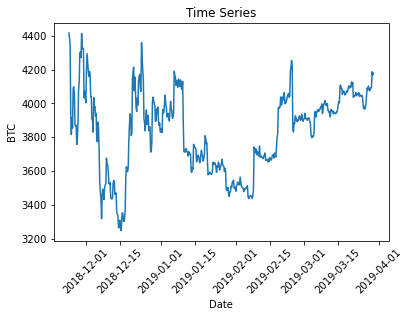

In [110]:
# Select the column of interest
column = sdf['btc_price']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('BTC')
plt.title('Time Series')
plt.xticks(rotation=45)
plt.show()


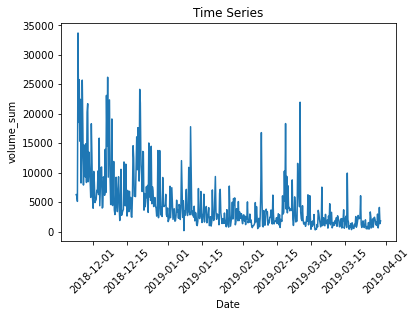

In [111]:
# Select the column of interest
column = sdf['volume_sum']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('volume_sum')
plt.title('Time Series')
plt.xticks(rotation=45)
plt.show()

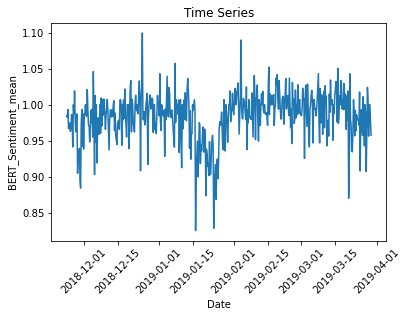

In [112]:
# Select the column of interest
column = sdf['BERT_Sentiment_mean']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('BERT_Sentiment_mean')
plt.title('Time Series')
plt.xticks(rotation=45)
plt.show()

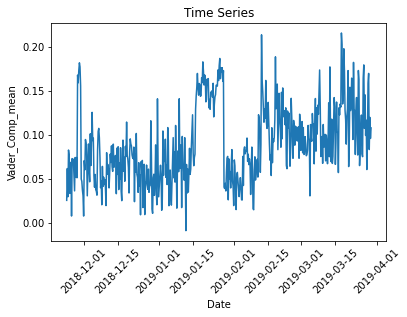

In [113]:
# Select the column of interest
column = sdf['Vader_Comp_mean']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('Vader_Comp_mean')
plt.title('Time Series')
plt.xticks(rotation=45)
plt.show()

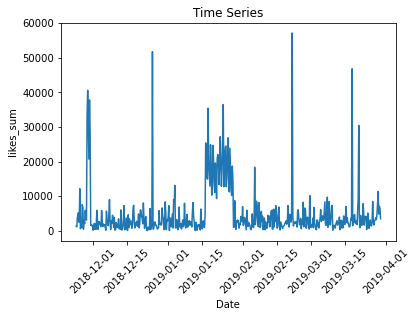

In [114]:
# Select the column of interest
column = sdf['likes_sum']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('likes_sum')
plt.title('Time Series')
plt.xticks(rotation=45)
plt.show()

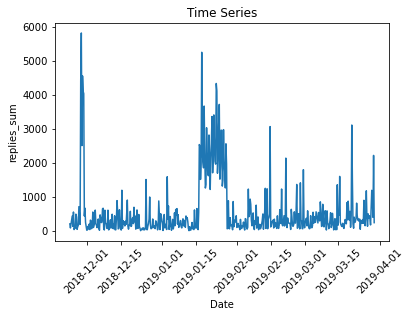

In [115]:
# Select the column of interest
column = sdf['replies_sum']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('replies_sum')
plt.title('Time Series')
plt.xticks(rotation=45)
plt.show()

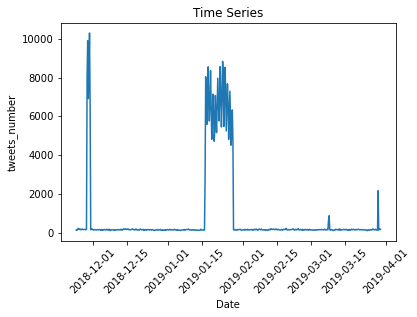

In [116]:
# Select the column of interest
column = sdf['num_tweets']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('tweets_number')
plt.title('Time Series')
plt.xticks(rotation=45)

plt.show()

In [103]:
correlation = sdf['likes_sum'].corr(sdf['Vader_Comp_mean'])
correlation

0.44032099447374556